# Finite Volume Advection Equation
Solving $u_t+au_x = \sigma \frac{\mathrm{d}^2 u}{\mathrm{d}x^2} $ using finite volumes with options for:
- first order upwind
- second order central upwind
- third order upwind
- flux limiting, either van Leer or 'standard' limiter

Diffusive term is solved using Crank-Nicolson.

In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(linewidth=110)

In [4]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.color_palette('colorblind')
from scipy import stats
import scipy.sparse.linalg

In [7]:
def solve_adv_diff_eqn(adv_solver='first_order_upwind', a=1, D=1, dt=0.001, dx=0.1, T_end=5, L=5,
                initial_dist=(lambda x: stats.norm.pdf(x, loc=0, scale=1))):

    N = int(T_end/dt)
    J = int(2*L/dx)
    t = np.linspace(0, T_end, N+1)
    x = np.linspace(-L, L , J+1)
    U = np.zeros((N+1, J+1), dtype= float)

    U_0 = initial_dist(x) #Initial Conditions
    U[0,] = U_0

    
    mu = D * dt/(dx**2)
#     _a = 0.5*mu
#     _b = 1 + mu
#     _c = 0.5*mu
    upper= -(0.5*mu)*np.ones(J)
    main = (1 + mu)*np.ones(J+1)
    lower= -(0.5*mu)*np.ones(J)
    top_right = 0#-0.5*mu
    bottom_left = 0#-0.5*mu
    diagonals = [bottom_left, lower, main, upper, top_right]
    A = scipy.sparse.diags(diagonals, [-J, -1,0,1, J], format="csc")
#     _d, _e, _f = [np.zeros(J+1) for _ in range(3)]
    b = np.zeros(J+1)
    
    def psi_1(theta): return 0
    def psi_2(theta): return 1/2
    def psi_3(theta): return 1/3 + (1/6)*theta
    def psi_flux(theta): return max(0,min(1, 1/3 + (1/6)*theta, theta))
    def psi_vl(theta): return 0.5*(theta+np.abs(theta))/(1+np.abs(theta))
    
    solvers = {'first_order_upwind': psi_1,
               'second_order_upwind': psi_2,
               'third_order_upwind': psi_3,
               'flux_limited_upwind': psi_flux,
               'van_Leer': psi_vl,
              }

    psi = solvers[str(adv_solver)]
    eps = 10**-18
    
    c = a * (dt/dx) 
    if abs(c)>1:
        warnings.warn('Method is likely to be unstable, CFL condition failed, c>1')
    for n in range(N):
        for j in range(J+1):  
            if j==0:
                flux_left = 0
            else:
                flux_left = flux_right

            if 1 < j < J-1:
                theta = (U[n,j] - U[n,j-1]) / (U[n,j+1] - U[n,j] + eps)
                theta_1 = (U[n,j+1] - U[n,j]) / (U[n,j+2] - U[n,j+1] + eps)
                #Check sign of wavespeed and adjust upwind accordingly
                neg_wave = (U[n, j+1] + psi(1/(theta_1+eps))*(U[n, j] - U[n, j+1]))
                pos_wave = (U[n, j] +  psi(theta)*(U[n, j+1] - U[n, j]))    
                adv_right = min(a,0)*neg_wave + max(a,0)*pos_wave 
                diff_right =   -0.5 *D* (U[n,j+1] -U[n,j])/dx
                flux_right = adv_right + diff_right 
                
            elif j==J-1 or j==1: 
                adv_right = (min(a,0)*U[n, j+1] + max(a,0)*U[n, j])
                diff_right =  -0.5 *D* (U[n,j+1] - U[n,j])/dx 
                flux_right = adv_right + diff_right 
            else:
                flux_right = 0
            #Build tridiagonal matrix
            b[j] = U[n, j]  + (dt/dx)*(flux_left-flux_right)
#             _e[j] = _c/(_b - _a*_e[j-1])
#             _f[j] = (_d[j] + _a*_f[j-1]) / (_b - _a*_e[j-1])
        b[0] = 0
        b[-1] = 0
        U[n+1, ] = scipy.sparse.linalg.spsolve(A,b) 
#         #Solve system
#         for j in range(J, 0, -1):
#             if j==0 or j==J:
#                 U[n+1,j] = 0
#             else:
#                 U[n+1, j] = _f[j] + _e[j]*U[n+1, j+1]

    mass_loss =  (1 - sum(U[-1,:])/sum(U[0,:]))*100
    print('{} mass loss was {:.5f}%'.format(adv_solver, mass_loss))
    return x, U

flux_limited_upwind mass loss was 0.00001%
van_Leer mass loss was 0.00001%
third_order_upwind mass loss was 0.00001%
second_order_upwind mass loss was 0.00001%
first_order_upwind mass loss was 0.00001%


C:\Users\s1415551\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\s1415551\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


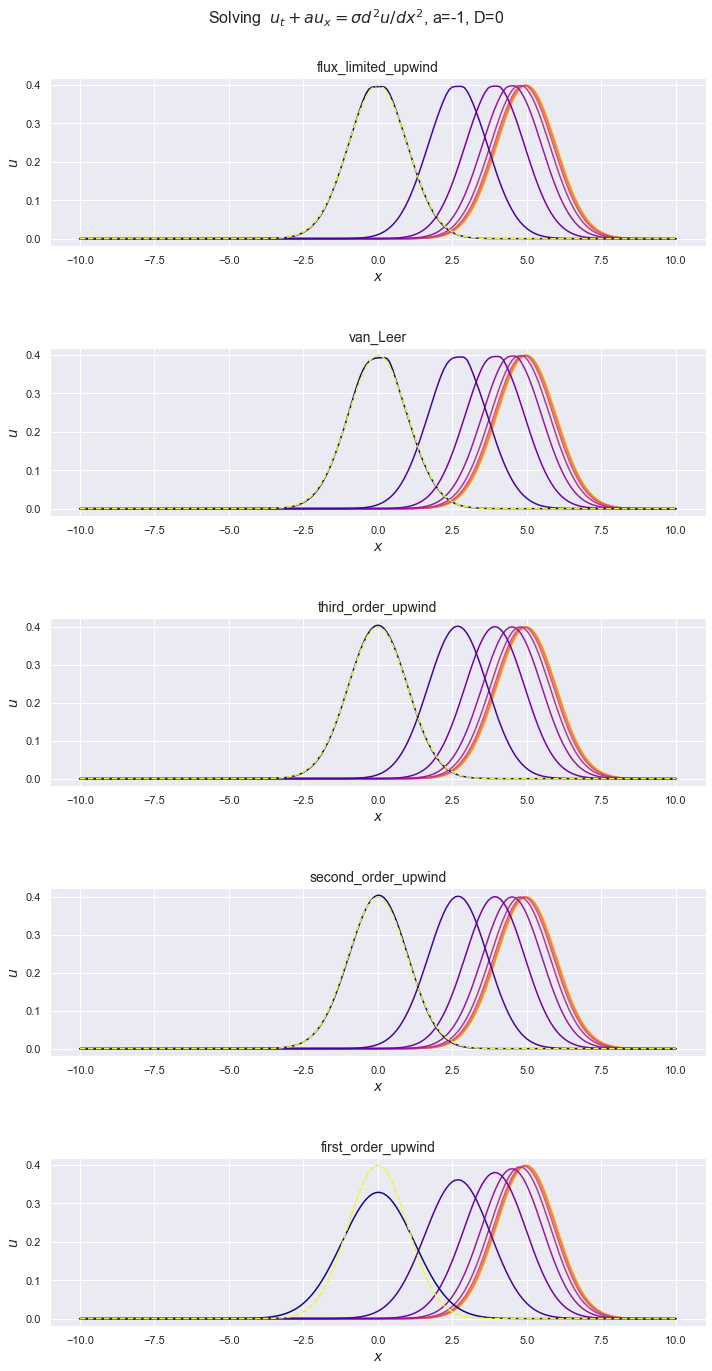

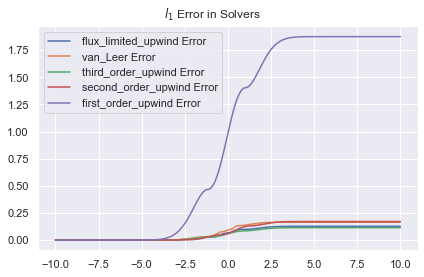

flux_limited_upwind mass loss was 0.00001%
van_Leer mass loss was 0.00001%
third_order_upwind mass loss was 0.00001%
second_order_upwind mass loss was 0.00001%
first_order_upwind mass loss was 0.00001%


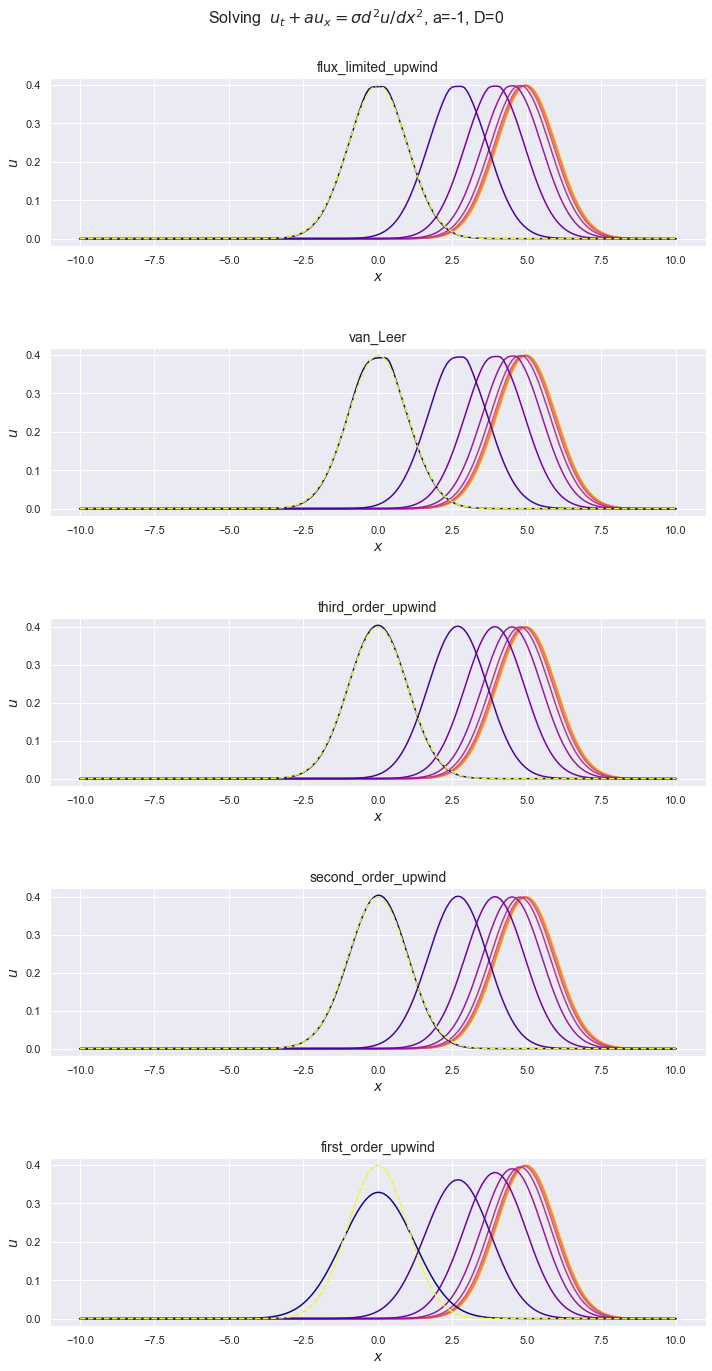

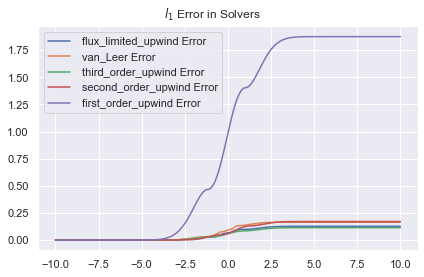

flux_limited_upwind mass loss was 0.00001%
van_Leer mass loss was 0.00001%
third_order_upwind mass loss was 0.00001%
second_order_upwind mass loss was 0.00001%
first_order_upwind mass loss was 0.00001%


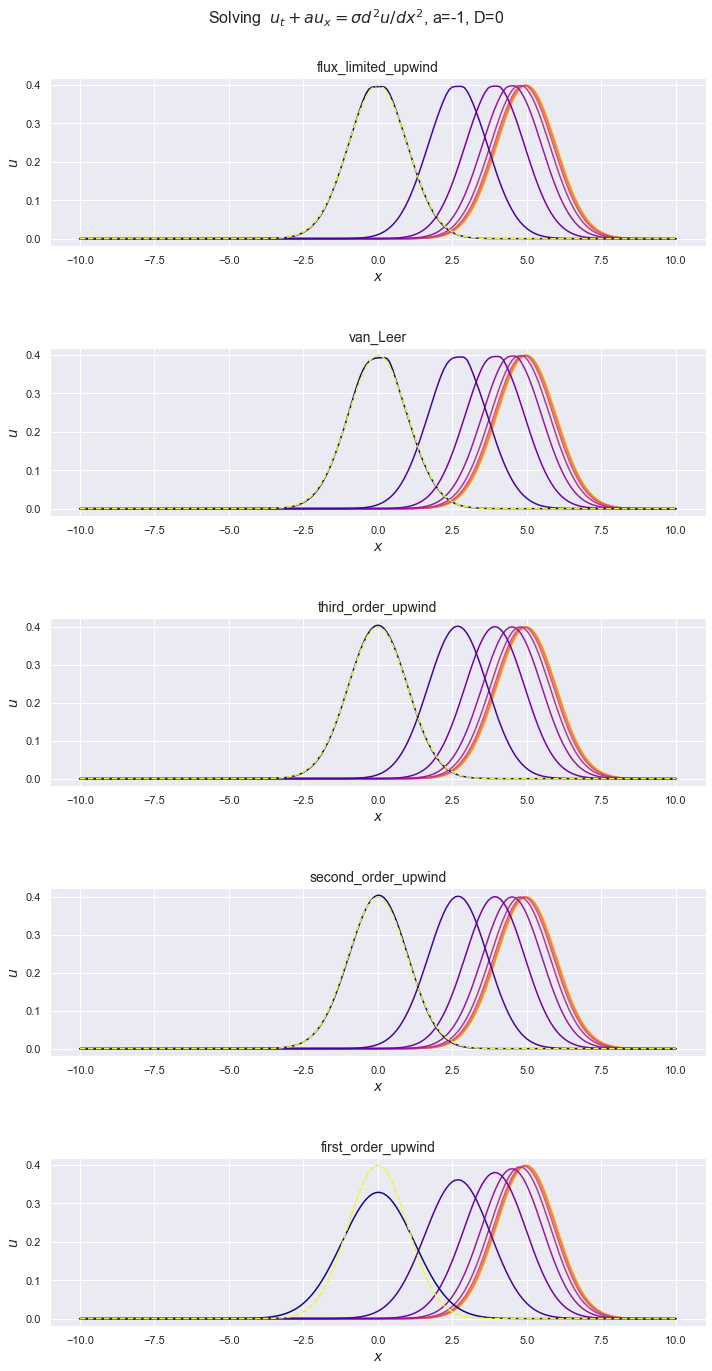

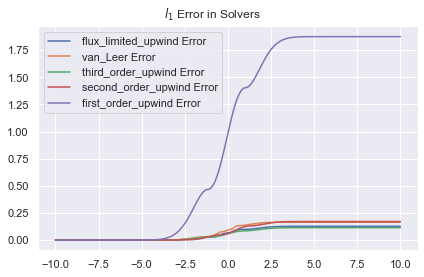

flux_limited_upwind mass loss was 0.00001%
van_Leer mass loss was 0.00001%
third_order_upwind mass loss was 0.00001%
second_order_upwind mass loss was 0.00001%
first_order_upwind mass loss was 0.00001%


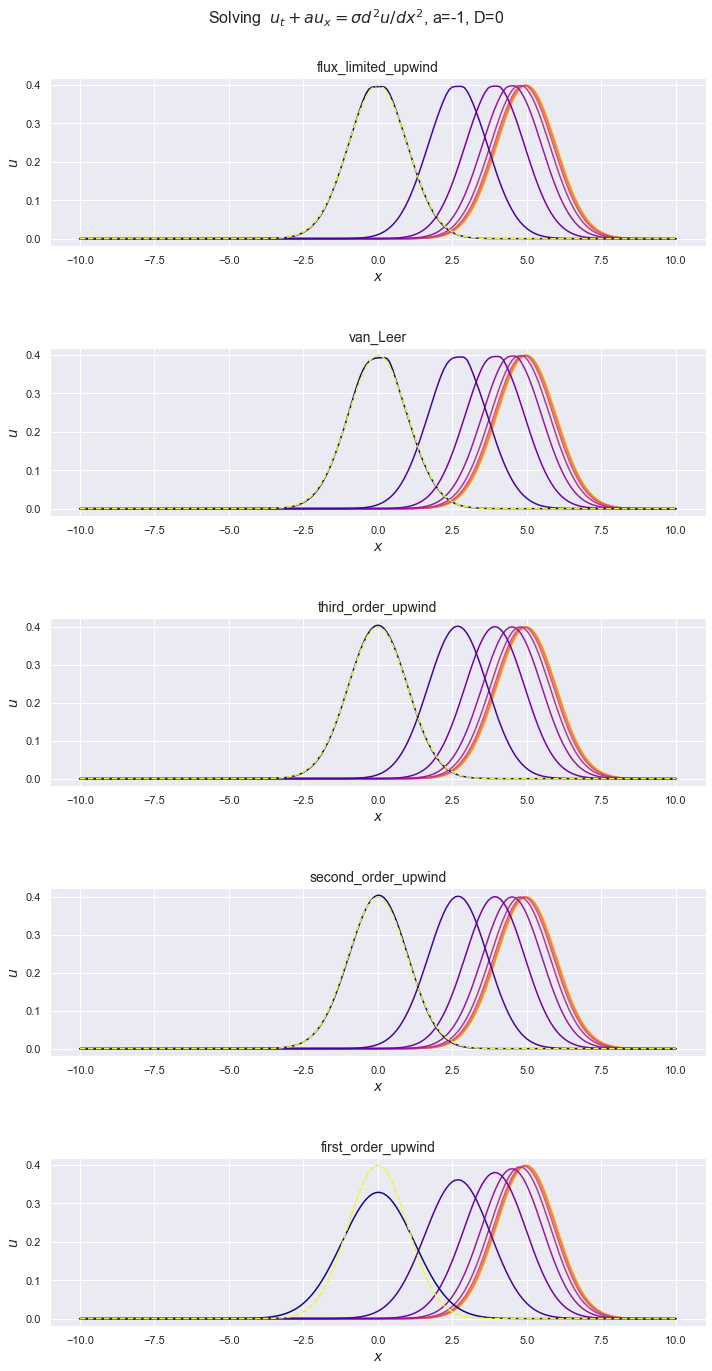

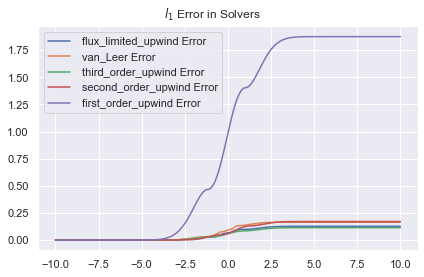

flux_limited_upwind mass loss was 0.00001%
van_Leer mass loss was 0.00001%
third_order_upwind mass loss was 0.00001%
second_order_upwind mass loss was 0.00001%
first_order_upwind mass loss was 0.00001%


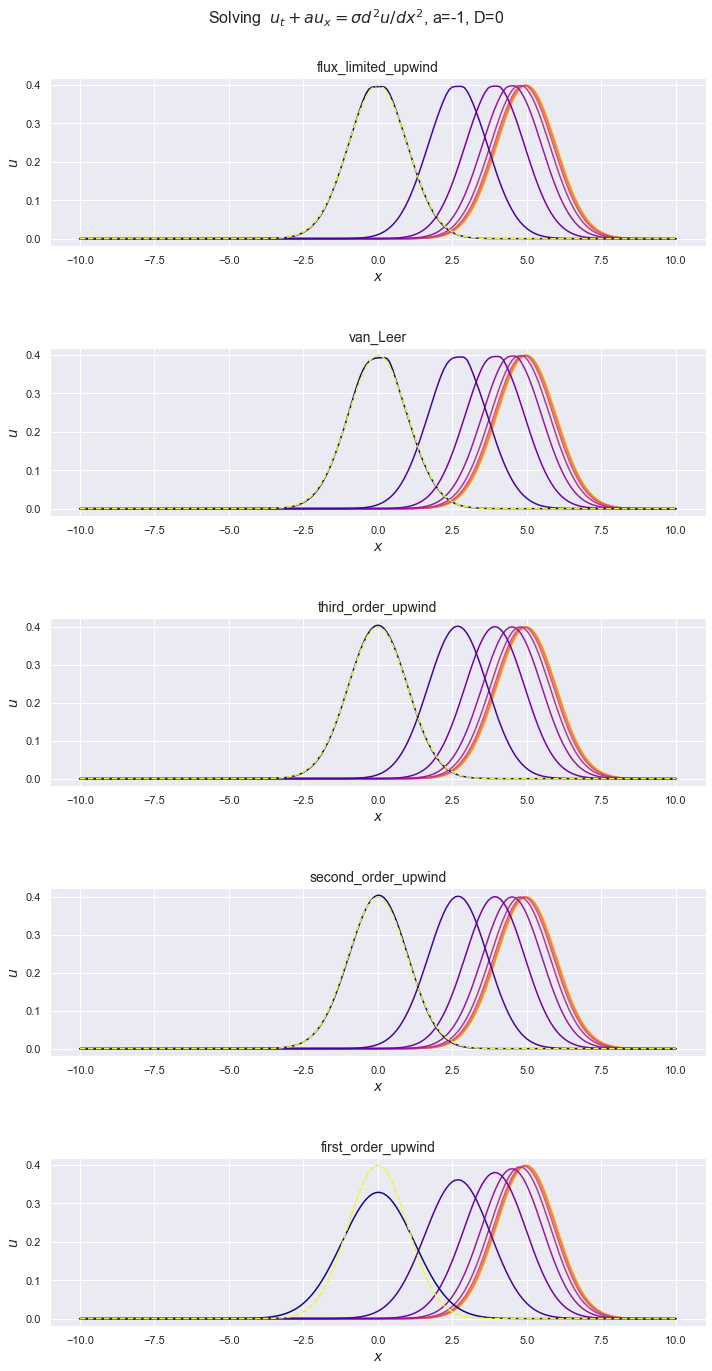

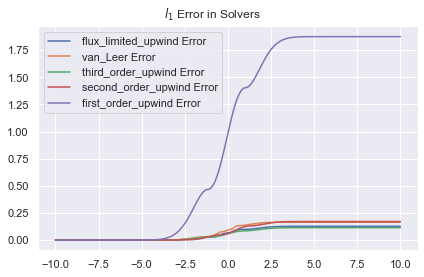

flux_limited_upwind mass loss was 0.00001%
van_Leer mass loss was 0.00001%
third_order_upwind mass loss was 0.00001%
second_order_upwind mass loss was 0.00001%
first_order_upwind mass loss was 0.00001%


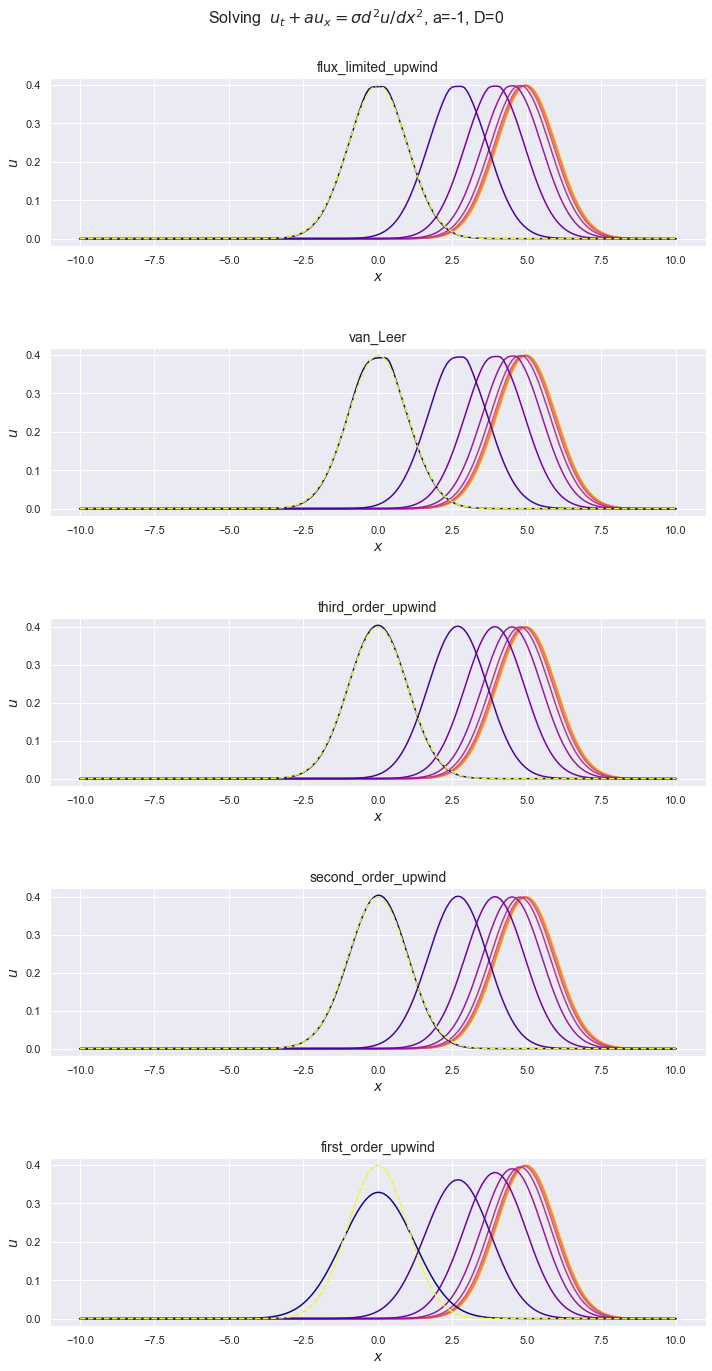

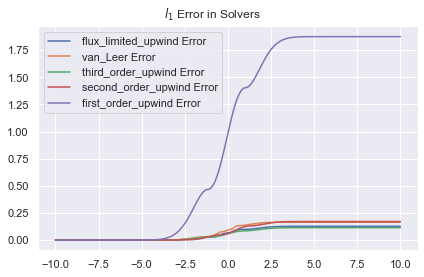

flux_limited_upwind mass loss was 0.00001%
van_Leer mass loss was 0.00001%
third_order_upwind mass loss was 0.00001%
second_order_upwind mass loss was 0.00001%
first_order_upwind mass loss was 0.00001%


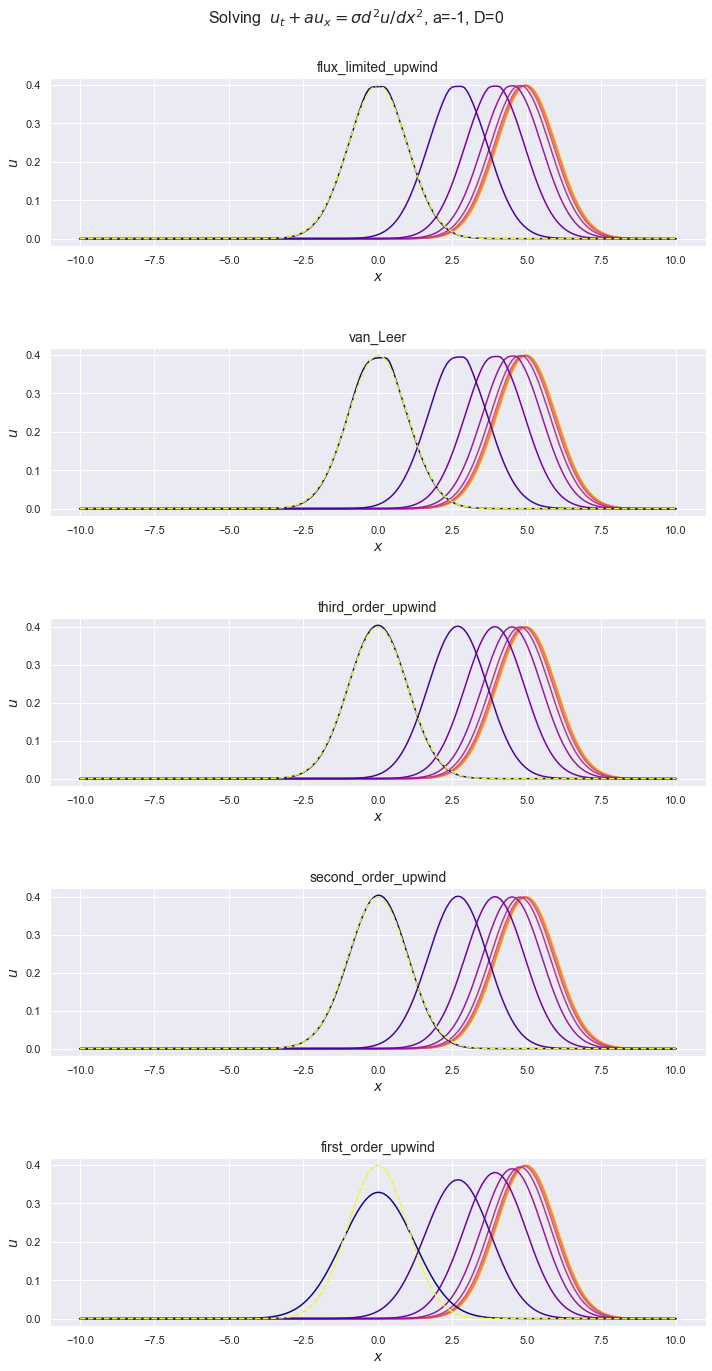

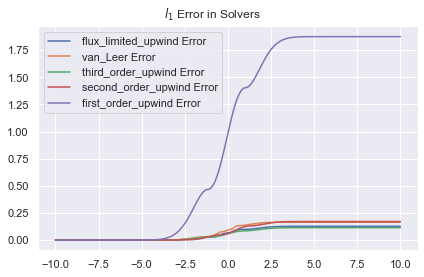

flux_limited_upwind mass loss was 0.00001%
van_Leer mass loss was 0.00001%
third_order_upwind mass loss was 0.00001%
second_order_upwind mass loss was 0.00001%
first_order_upwind mass loss was 0.00001%


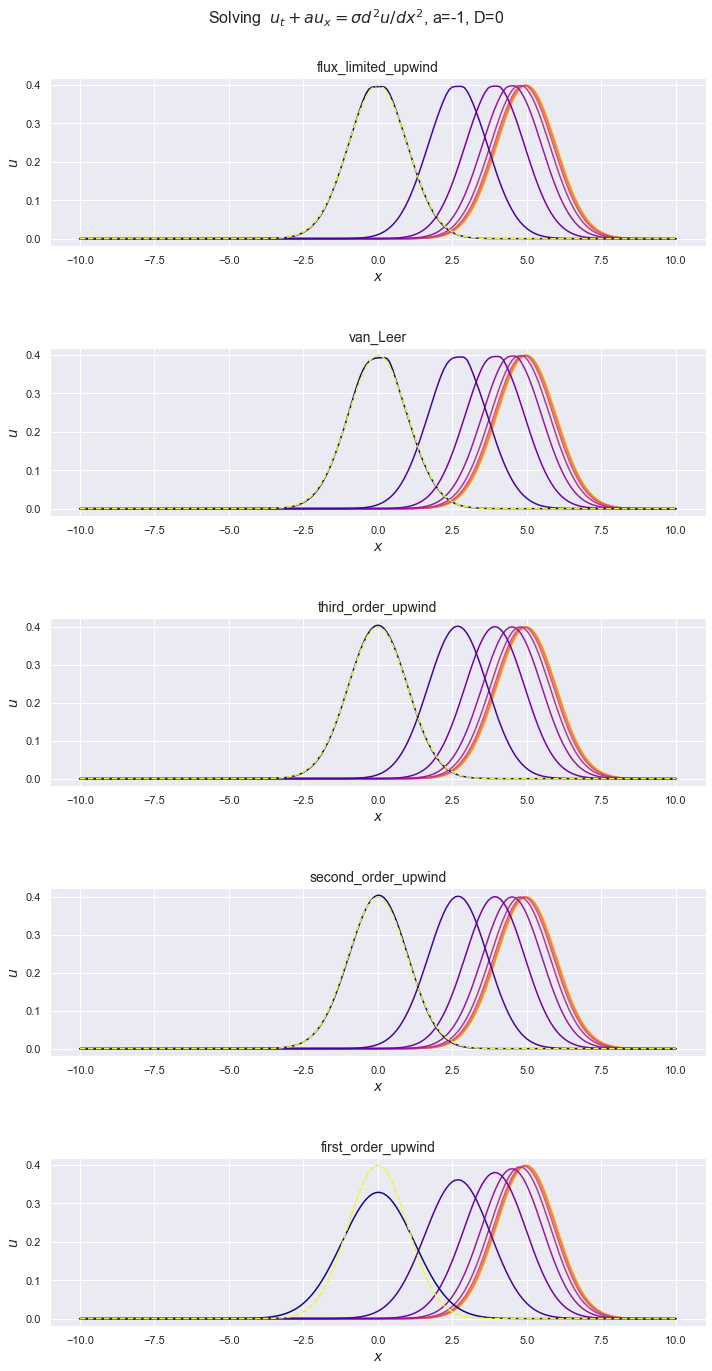

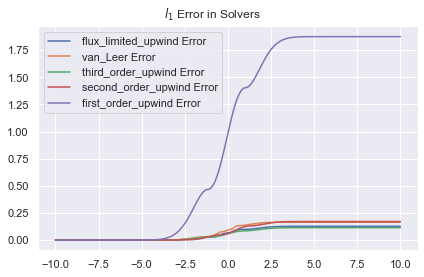

30.1 s ± 1.29 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
wavespeed = -1
diffusion = 0
T_final = 5
length = 10

def gaussian(x): return stats.norm.pdf(x, loc=5, scale=1)
def block(x): return np.array([float(i>=-7.9 and i<=-6.9) for i in x])
def bump(x,a):
    f = np.zeros(len(x))
    for i in range(len(x)):
        if a <= np.abs(x[i]) <= a+1:
            f[i] = np.exp(1/(x[i]**2-(a+1)**2))/np.exp(1/(a**2-(a+1)**2))
        elif np.abs(x[i]) < a:
            f[i] = 1
        else:
            f[i] = 0
    return f

initial_data = gaussian #block #lambda x: bump(x,0.8)
adv_solvers = ['flux_limited_upwind', 'van_Leer','third_order_upwind','second_order_upwind','first_order_upwind']


colormap = plt.get_cmap('plasma')
fig, ax = plt.subplots(len(adv_solvers), 1, figsize=(10,20))
fig.suptitle(r'Solving  $u_t+au_x = \sigma  d^2 u/dx^2$, a={}, D={}'.format(wavespeed,diffusion), fontsize=16)
err_fig, err_ax= plt.subplots()

if len(adv_solvers) == 1:
    ax = [ax]
for idx, solver in enumerate(adv_solvers):
    adv_x, adv_sol = solve_adv_diff_eqn(adv_solver=solver, a=wavespeed, D=diffusion, T_end=T_final, dx=0.1, dt=0.005, L=length, initial_dist=initial_data)
    ax[idx].set_title(solver, fontsize=14)
    ax[idx].set_xlabel(r'$x$', fontsize=14)
    ax[idx].set_ylabel(r'$u$', fontsize=14)
    ax[idx].set_prop_cycle(color=[colormap(k) for k in np.linspace(1, 0, 10)])
    for i in np.logspace(0, np.log10(np.size(adv_sol, axis=0)-1), num=10):
        ax[idx].plot(adv_x, adv_sol[int(i),])
    ax[idx].plot(adv_x, initial_data(adv_x-wavespeed*T_final), ls='--')
    true_sol = initial_data(adv_x-wavespeed*T_final)
    err_ax.plot(adv_x, np.cumsum(abs(true_sol - adv_sol[-1,])), label=' {} Error'.format(solver))
    err_ax.legend()

err_fig.suptitle(r'$l_1$ Error in Solvers')
err_fig.show()    
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.6)
fig.show()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

savepath = './'
#Uncomment to save in parent directory
# plt.savefig(savepath+'{}.jpg'.format('upwind'), format='jpg', dpi=1000)
plt.show()